The code in this Jupyter notebook produces the supplemental figures in "Drivers of Physical and Economic Impacts of Water Scarcity in Latin America and the Caribbean."

Please contact Abigail Birnbaum at abigail.birnbaum@tufts.edu with any questions.

# Import Statements

In [1]:
# These are the packages required for this code. 
# Make sure that they're installed in your Python 3 environment
# You can create a virtual environment that has these packages installed using the LACwaterscarcity_env.yml file
import pandas as pd
#import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore') #for not printing warnings
import numpy as np
import matplotlib.colors as mcolors

In [2]:
# this is the path to where all the data is stored to produce these figures
# make sure it is correct for your machine
#fpath = 'C:/Users/abirnb01/Documents/Research/NEXO-UA/LACwaterscarcity/data/'
fpath = 'C:/Users/birnb/Documents/Tufts Research/NEXO-UA/LACwaterscarcity/data/'

# Load in data

In [3]:
#Path to where data is kept. Change this to reflect the appropriate location on your machine

#load pickle that contains values for scarcity metrics
metrics = pd.read_pickle(fpath+'query_results/scarcity_metrics')

#global weighted average water price for each scenario
#for each scenario, calculate the average global water price
glob_wprice = pd.read_pickle(fpath+'query_results/glob_wprice') #units are already $2020/m3

#convert any dollar amounts from $1975 to $2020
#use World Bank deflator: https://data.worldbank.org/indicator/NY.GDP.DEFL.ZS?locations=US&view=chart
#in 1975, 28.511 and in 2020, 108.556
#so multiply prices by 3.81 (108.556/28.511) to get values in $2020
cf = 3.81
metrics['price_scenario'] = metrics['price_scenario']*cf #units are now $2020/m3
metrics['price_unlimited'] = metrics['price_unlimited']*cf #units are now $2020/m3
metrics['profit_scenario'] = metrics['profit_scenario']*cf #units are now $2020
metrics['profit_unlimited'] = metrics['profit_unlimited']*cf #units are now $2020

#merge the scarcity metrics dataframe with the global water price dataframe
metrics_glob = metrics.merge(glob_wprice,on=['year','res','esm','tax','soc','ag','osf','gw'])

esm_dict = {1:'gfdl',2:'hadgem2',3:'ipsl',4:'miroc',5:'noresm'}
ag_dict = {1:'ssp1',2:'ssp2',3:'ssp3',4:'ssp4',5:'ssp5'}
soc_dict = {1:'ssp1',2:'ssp2',3:'ssp3',4:'ssp4',5:'ssp5'}
res_dict = {1:'restricted',2:'expanded'}
gw_dict = {1:'low',2:'med',3:'high'}
tax_dict = {1:'ffict',2:'uct'}
osf_dict = {1:'from_soc',2:'from_ag'}

#rename all of the parameter assumptions with their longform name
metrics_glob['esm'] = metrics_glob['esm'].map(esm_dict)
metrics_glob['ag'] = metrics_glob['ag'].map(ag_dict)
metrics_glob['soc'] = metrics_glob['soc'].map(soc_dict)
metrics_glob['tax'] = metrics_glob['tax'].map(tax_dict)
metrics_glob['res'] = metrics_glob['res'].map(res_dict)
metrics_glob['gw'] = metrics_glob['gw'].map(gw_dict)
metrics_glob['osf'] = metrics_glob['osf'].map(osf_dict)

#save as CSV
#metrics_glob.to_csv(fpath+'query_results/scarcity_metrics.csv')


# Figure S1. Map of LAC basins

Figure S1 was made using ArcGIS Pro. The shapefile for Latin America and Caribbean GCAM water basins can be found at 
LACwaterscarcity/data/map_shapefiles/LAC_basins/lac_basins.shp

The shapefiles were originally downloaded from: https://zenodo.org/record/4014308#.YhekfOjMKUk

# Figure S2. Histogram for Water Price Threshold

Figure S2 plots a histogram of the percent of basins that have a water price greater than or equal to the global weighted average water price across all scenarios in 2100

In [4]:
wprice_all = pd.read_pickle(fpath+'query_results/wprice_allbasins') #water price for all basins/scenarios in year 2100

wprice_all['price_scenario'] = cf*wprice_all['price_scenario'] #conver to $2020/m3

#merge with global water price
wprice_merge = wprice_all.merge(glob_wprice,on=['year','gw','res','esm','tax','soc','ag','osf'])

#for each scenario, how many basins are greater than or equal to 10% higher than global weighted average water price
wprice_merge['gt_globwp'] = wprice_merge['price_scenario']>=1.1*wprice_merge['weighted_price_scenario']

#sum up # basins greater than or equal to 10% higher than global weighted average water price
wprice_ct = wprice_merge.groupby(['year','tax','osf','ag','soc','gw','esm','res'])['gt_globwp'].sum()
wprice_ct = wprice_ct.reset_index()

#now calculate % of total basins
n = len(wprice_all['basin'].unique()) #number of basins
wprice_ct['gt_globwp'] = 100*(wprice_ct['gt_globwp']/n)


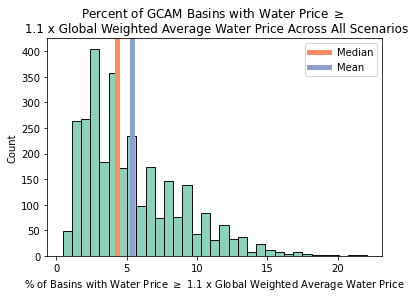

Min:  0.43
Median:  4.33
Mean:  5.38
Max:  22.08


In [5]:
#Plot histogram
clist = sns.color_palette('Set2',3) #get color palette
sns.histplot(data=wprice_ct['gt_globwp'],color=clist[0]) #plot data on histogram
plt.title('Percent of GCAM Basins with Water Price $\geq$ \n 1.1 x Global Weighted Average Water Price Across All Scenarios')
plt.axvline(np.median(wprice_ct['gt_globwp']),color=clist[1],label='Median',lw=5)
plt.axvline(np.mean(wprice_ct['gt_globwp']),color=clist[2],label='Mean',lw=5)
plt.xlabel('% of Basins with Water Price $\geq$ 1.1 x Global Weighted Average Water Price')
plt.legend()
plt.show()
print('Min: ',round(np.min(wprice_ct['gt_globwp']),2))
print('Median: ',round(np.median(wprice_ct['gt_globwp']),2))
print('Mean: ',round(np.mean(wprice_ct['gt_globwp']),2))
print('Max: ',round(np.max(wprice_ct['gt_globwp']),2))

# Figure S3. Histogram of Crop Profit Changes

Figure S3 plots a histogram of the percent change in crop profits across all scenarios and all basins in 2100

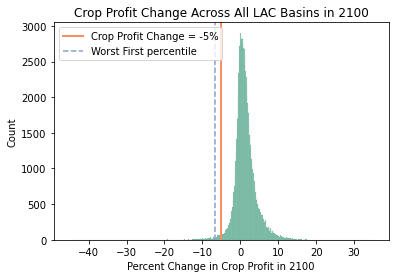

Min:  -45.19
Max:  35.07
Worst First Percentile:  -6.65
Percentile of -5%:  0.02


In [6]:
m2100 = metrics[(metrics.year==2100)]

clist = sns.color_palette('Set2',4)

sns.histplot(data=m2100,x='profit_pchange',color=clist[0])
plt.axvline(-5,color=clist[1],label='Crop Profit Change = -5%',lw=2)
plt.axvline(m2100['profit_pchange'].quantile(0.01),linestyle='--',label='Worst First percentile',color=clist[2])
plt.xlabel('Percent Change in Crop Profit in 2100')
plt.legend()
plt.title('Crop Profit Change Across All LAC Basins in 2100')
plt.show()

print('Min: ',round(np.min(m2100['profit_pchange']),2))
print('Max: ',round(np.max(m2100['profit_pchange']),2))
print('Worst First Percentile: ',round(m2100['profit_pchange'].quantile(0.01),2))

#m2100_sort = m2100.sort_values('profit_pchange',ascending=True #sort all of the crop profit change values in ascending order
m2100['rank'] = m2100['profit_pchange'].rank(pct=True) #rank the crop profit change values
find_val = m2100[(m2100['profit_pchange']>-5.001) & (m2100['profit_pchange']<-4.999)] #find values near -5%
print('Percentile of -5%: ',round(find_val['rank'].iloc[0],2)) #print values near -5%, what is the rank?

# Figures S4-S7. Sensitivity Analysis

Figures S4-S7 show the results of the sensitivity analysis performed on the water price and crop profit change thresholds. To produce these figures, run CART_classification_cropprofit.R and CART_classification_waterprice.R, changing the thresholds to 1.0*global weighted average water price and 1.2* global weighted average water price for water price and -4% and -6% for crop proift change

# Figure S8. Regression heatmaps for 2050 and 2075

To produce these heatmaps, run the code to produce Figure 2 (in main_figures_scripts.ipynb) using the results from running the regression analysis for 2050 and 2075 which can be found in the data/CART_results directory

# Figure S9. Labeled heatmap for 2100

To produce this heatmap, run the code to produce Figure 2 in main_figures_script.ipynb. Make sure annot=True and fmt = '.2f' when calling sns.heatmap():

sns.heatmap(df_pivot,cmap=clmap, 
                cbar_kws={'label':metric,'orientation':'horizontal'},
                xticklabels=['AG','SOC','OSF','ESM','GW','RES','TAX'], yticklabels=True,
               annot=True,fmt='.2f')

# Figure S10. Scatterplots of Exposure to Severe Outcomes vs Range of Variability for 2050 and 2075

To produce these scatterplots, run the code to produce Figure 3 in main_figures_script.ipynb, changing the variable yr to 2050 or 2075

 # Figure S11. Runoff for different ESMs

Plot runoff for the different ESMs under restricted reservoir storage assumptions for the six basins discussion in the results section 3.2 (Rio Grande, North Chile-Pacific Coast, Peru-Pacific Coast, Rio Verde, East Brazil-South Atlantic Coast, Mexico-Interior). To plot under expanded reservoir storage, change "lac_runoff.res=='rs' to lac_runoff.res=='exp'

In [7]:
lac_runoff = pd.read_pickle(fpath+'query_results/LAC_runoff') #load in the runoff data

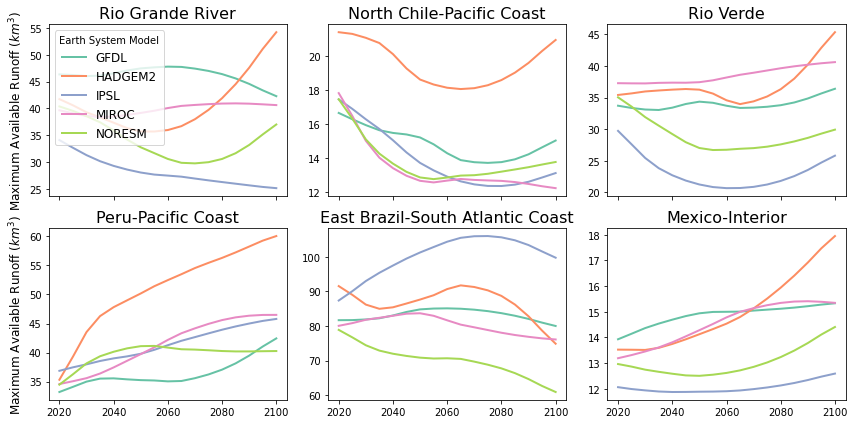

In [8]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(12,6),sharex=True)
axes = [ax1,ax2,ax3,ax4,ax5,ax6]

#rename Rio Grande basin to match others
lac_runoff['basin'] = lac_runoff['basin'].replace({'Rio Grande River','Rio Grande'})

basins = ['Rio Grande River','North Chile-Pacific Coast','Rio Verde','Peru-Pacific Coast',
          'East Brazil-South Atlantic Coast','Mexico-Interior']

for i in range(len(axes)): #loop through the basins
    b = basins[i]
    sns.lineplot(ax=axes[i],data=lac_runoff[(lac_runoff.basin==b) & (lac_runoff.res=='rs')],x='year',y='value',hue='esm',
                palette='Set2',hue_order=['gfdl','hadgem','ipsl','miroc','noresm'],lw=2,legend=False)
    axes[i].set_title(b,size=16)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    if (i==0) or (i==3):
        if i== 0:
            axes[i].legend(loc='upper left',title='Earth System Model',labels=['GFDL','HADGEM2','IPSL','MIROC','NORESM'],fontsize=12)
        axes[i].set_ylabel('Maximum Available Runoff ($km^3$)',fontsize=12)
plt.tight_layout()
plt.show()

# Figure S12. Global UCT vs FFICT crop production and Mexico region net exports

This figure produces two suplots - a) is global cropland allocation under a UCT vs FFICT (all other parameter assumptions are the same) and b) is net exports of crops (in Mt) in the Mexico region under the UCT vs FFICT (with all other parameter assumptions held equal)

In [9]:
#global land allocated to crops
lalloc_glob = pd.read_pickle(fpath+'query_results/land_crop') #global ag production
lalloc_glob_tax = lalloc_glob[(lalloc_glob.ssp==2)&(lalloc_glob.ag==5)&(lalloc_glob.gw==1)&(lalloc_glob.res==1)&
                         (lalloc_glob.esm==2) & (lalloc_glob.soc==3)]
lalloc_glob_tax = lalloc_glob_tax[lalloc_glob_tax.landleaf.isin(['Corn','FiberCrop','FodderGrass',
                                                                'FodderHerb','MiscCrop','OilCrop',
                                                                'OtherGrain','PalmFruit','Rice',
                                                                'Root_Tuber','SugarCrop','Wheat'])]
lalloc_glob_tax = lalloc_glob_tax.groupby(['Units','year','gw','res','esm','tax','ssp','ag','soc'])['value'].sum()
lalloc_glob_tax = lalloc_glob_tax.reset_index()

In [10]:
#crop production in Mexico

#read in crop consumption and production datasets for this basin
#already limited to scenarios of interest: ssp_ag5_soc3_gwlo_rs_hadgem_NDC_Tax_uct and ssp_ag5_soc3_gwlo_rs_hadgem_NDC_Tax_ffict
# already removed non MT crops and pasture
crop_csmp = pd.read_pickle(fpath+'query_results/crop_csmp_mxc_tax')
crop_prod = pd.read_pickle(fpath+'query_results/crop_prod_mxc_tax')

#sum up consumption across crops
crop_csmp_sum = crop_csmp.groupby(['scenario','year','Units','tax'])['value'].sum()
crop_csmp_sum = crop_csmp_sum.reset_index()

#sum up production across crops
crop_prod_sum = crop_prod.groupby(['scenario','year','Units','tax'])['value'].sum()
crop_prod_sum = crop_prod_sum.reset_index()

#merge production and consumption dataframes
crop_merge = crop_csmp_sum.merge(crop_prod_sum,on=['scenario','year','Units','tax'],
                                suffixes=['_csmp','_prod'])

#calculate production - consumption (net exports in MT)
crop_merge['value_diff'] = crop_merge['value_prod'] - crop_merge['value_csmp']

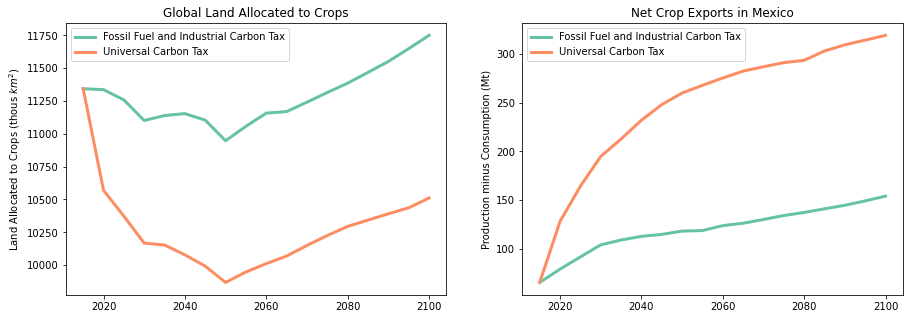

In [11]:
#create plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(ax=ax1,data=lalloc_glob_tax,x='year',y='value',hue='tax',palette='Set2', lw=3)
ax1.set_xlabel('')
ax1.set_ylabel('Land Allocated to Crops (thous $km^2$)')
ax1.set_title('Global Land Allocated to Crops')
ax1.legend(labels=['Fossil Fuel and Industrial Carbon Tax',
                               'Universal Carbon Tax'])

sns.lineplot(ax=ax2,data=crop_merge,x='year',y='value_diff',hue='tax',palette='Set2',lw=3)
ax2.set_xlabel('')
ax2.set_ylabel('Production minus Consumption (Mt)')
ax2.legend(labels=['Fossil Fuel and Industrial Carbon Tax',
                               'Universal Carbon Tax'])
ax2.set_title('Net Crop Exports in Mexico')

plt.show()

# Figures S13-S17.

Figures S13-S17 show classification tree structures in 2050 and 2075. To reproduce these figures, run the scripts in the main_figures directory CART_classification_physicalwaterscarcity.R, CART_classification_waterprice.R, and CART_classification_cropprofit.R but change the year to 2050 or 2075 as appropriate

# Figure S18-S19. Land allocation in East Brazil-South Atlantic Coast and Mexico-Interior basins 

In [12]:
#stacked barplot overtime

def plot_landchange(df,plt_title):

    """Plot of land allocation for basin in scenarios - add more to this description
    Inputs:
    df = dataframe with land allocation for given water basin through 2100 for a scenario with FFICT and a 
    scenario with UCT (all other parameter assumptions are the same)
    Outputs:
    plot of land allocation change since 2015 for UCT and FFICT
    """
    sectors = df.crop.unique()[:] #list of land types
    #list of years since 2015
    years = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]

    #split up land into different categories
    crops = ['Corn','FiberCrop','FodderGrass','FodderHerb',
            'MiscCrop', 'OilCrop','OtherGrain','Rice','Root_Tuber',
            'SugarCrop','Wheat','PalmFruit']
    bmass =  ['biomass_grass','biomass_tree']
    protected_land =  ['ProtectedGrassland','ProtectedShrubland',
            'ProtectedUnmanagedPasture','ProtectedUnmanagedForest']
    forest = ['Forest','UnmanagedForest']
    nonarable = ['Tundra','RockIceDesert','UrbanLand']
    grassshrub =  ['Grassland','Shrubland']
    pasture = ['Pasture','UnmanagedPasture']
    otherarable = ['OtherArableLand']

    landtype_list = [crops,bmass,protected_land,forest,nonarable,grassshrub,pasture,otherarable]
    landtype_list_name = ['Crops','Biomass','Protected Land','Forest (not protected)','Non-Arable Land',
                         'Grassland/Shrubland','Pasture','Other Arable Land']

    #categorize each land use by type
    df['land_type'] = ''
    for i in range(len(landtype_list[:])): #loop through land types
        df.loc[df['crop'].isin(landtype_list[i]),'land_type'] = landtype_list_name[i]

    df_group = df.groupby(['Units','year','basin','tax','land_type'])['value'].sum() #sum across land types
    df_group = df_group.reset_index()

    #create dataframes for UCT and FFICT (limit to years 2015 and later)
    df_uct = df_group[(df_group.tax=='uct') & (df_group.year>=2015)]
    df_ffict = df_group[(df_group.tax=='ffict') & (df_group.year>=2015)]

    #create column "val_5" that represents the value in 2015
    df_uct['val_2015'] = 0
    df_ffict['val_2015'] = 0

    #get value in 2015
    for i in range(len(landtype_list_name)): #loop through land types
        for j in range(len(years)): #loop through years
            yr = years[j]
            val2015_uct = df_uct[(df_uct['land_type']==landtype_list_name[i]) & (df_uct['year']==2015)]['value'].iloc[0]
            val2015_ffict = df_ffict[(df_ffict['land_type']==landtype_list_name[i]) & (df_ffict['year']==2015)]['value'].iloc[0]       
            df_uct.loc[(df_uct['land_type']==landtype_list_name[i]) & (df_uct['year']==yr),'val_2015'] = val2015_uct
            df_ffict.loc[(df_ffict['land_type']==landtype_list_name[i]) & (df_ffict['year']==yr),'val_2015'] = val2015_ffict

    #calculate time period change (difference in value from 2015 to yr)
    df_uct['diff_2015'] = df_uct['value'] - df_uct['val_2015']
    df_ffict['diff_2015'] = df_ffict['value'] - df_ffict['val_2015']

    #pivot table (rearrange table for stacked bar chart)
    #remove protected land and non-arable land (don't change)
    table_uct = pd.pivot_table(df_uct[(df_uct.year>2015) & (~df_uct.land_type.isin(['Protected Land','Non-Arable Land']))], 
                               values='diff_2015', index=['year'],
                        columns=['land_type'])
    table_ffict = pd.pivot_table(df_ffict[(df_ffict.year>2015) & (~df_ffict.land_type.isin(['Protected Land','Non-Arable Land']))], 
                                 values='diff_2015', index=['year'],
                        columns=['land_type'])

    #PLOTTING
    fig,(ax1,ax2) = plt.subplots(1,2,sharey=True)

    #dictionary of colors
    c_list = {'Crops':'#ffff99',
              'Biomass':'#b2df8a',
                    'Forest (not protected)':'#33a02c',
                   'Non-Arable Land':'#fb9a99',
                   'Grassland/Shrubland':'#a6cee3',
                   'Pasture':'#fdbf6f',
                 'Other Arable Land':'#1f78b4',
             'Protected Land':'#b3b3b3'}

    #plot uct
    table_uct.plot.bar(ax=ax1,y=table_uct.columns,stacked=True,figsize=(10,5),color=c_list,legend=False)
    ax1.set_xlabel('')
    ax1.set_xticks([0,4,8,12,16])
    ax1.set_xticklabels([2020,2040,2060,2080,2100],rotation=0,fontsize=12)
    ax1.set_ylabel('$\Delta$Land Allocation from 2015 (thous $km^2$)',fontsize=12)
    ax1.set_title('Universal Carbon Tax',fontsize=12)
    ax1.axhline(c='black',lw=0.5)

    #plot ffict
    table_ffict.plot.bar(ax=ax2,y=table_ffict.columns,stacked=True,figsize=(10,5),color=c_list,legend=False)
    ax2.set_xlabel('')
    ax2.set_xticks([0,4,8,12,16])
    ax2.set_xticklabels([2020,2040,2060,2080,2100],rotation=0,fontsize=12)
    ax2.set_title('Fossil Fuel and Industrial Carbon Tax',fontsize=12)
    ax2.axhline(c='black',lw=0.5)
    
    #set legend
    ax2.legend(title='Land Type',ncol=1,bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(plt_title,fontsize=16)

    plt.tight_layout()
    plt.show()
    
    return df_uct,df_ffict

### Figure S18. Land Allocation over time under UCT vs FFICT in East Brazil-South Atlantic Coast

This figure displays land allocation change from 2015 in the East Brazil-South Atlantic Coast basin under two scenarios that share all parameter assumptions except for TAX (one is FFICT, one is UCT).

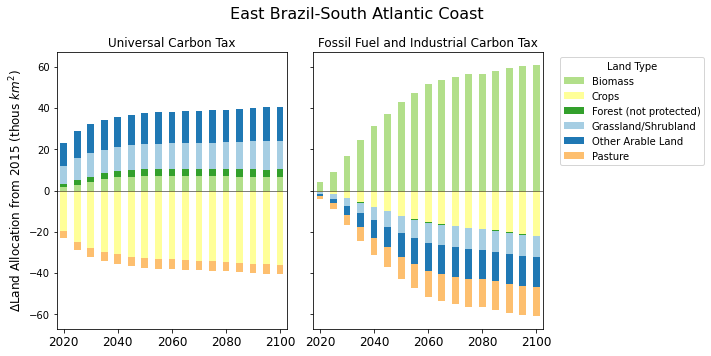

In [13]:
ebsac_lalloc_tax = pd.read_pickle(fpath+'query_results/ebsac_tax_lalloc')
ebsac_uct, ebsac_ffict = plot_landchange(ebsac_lalloc_tax,'East Brazil-South Atlantic Coast')

### Figure S19. Land Allocation over time under UCT vs FFICT in Mexico-Interior

This figure displays land allocation change from 2015 in the Mexico-Interior basin under two scenarios that share all parameter assumptions except for TAX (one is FFICT, one is UCT).

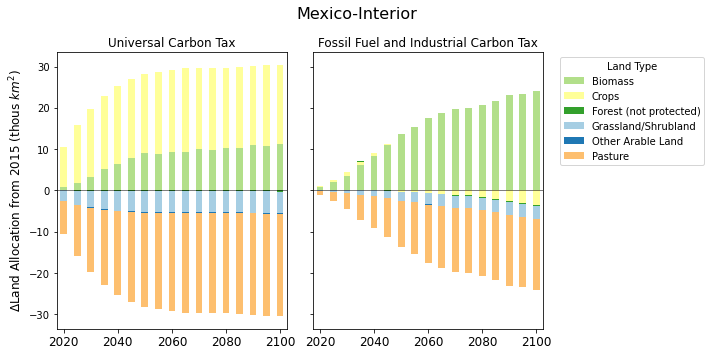

In [14]:
mexint_lalloc_tax = pd.read_pickle(fpath+'query_results/mexint_tax_lalloc')
mexint_uct, mexint_ffict = plot_landchange(mexint_lalloc_tax,'Mexico-Interior')

# Figure S20. Crop Production in East Brazil-South Atlantic Coast and Mexico-Interior (by ESM)

This figure plots crop production in the East Brazil-South Atlantic Coast and Mexico Interior basins over time for five scenarios that share all parameter assumptions except for ESM. 

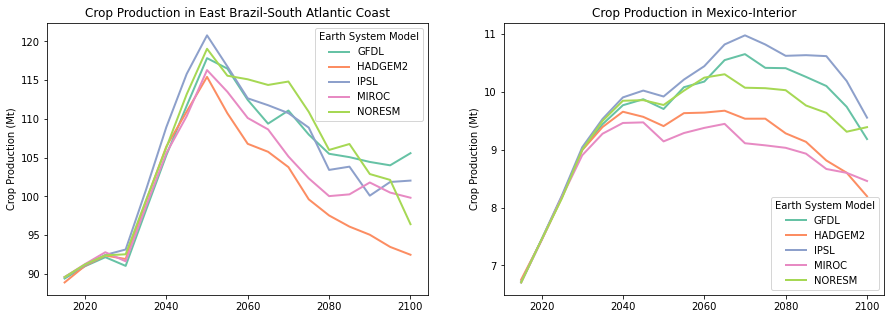

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

ebsac_agprod_esm = pd.read_pickle(fpath+'query_results/ebsac_esm_agprod')

#sum across technologies
ebsac_agprod_esm_sum = ebsac_agprod_esm.groupby(['Units','sector','output','year','esm'])['value'].sum()
ebsac_agprod_esm_sum = ebsac_agprod_esm_sum.reset_index()

#sum up across sectors - exclude biomass, forest, and pasture
ebsac_agprod_esm_sum = ebsac_agprod_esm_sum[~(ebsac_agprod_esm_sum['sector'].isin(['biomass','Pasture','Forest']))]
ebsac_agprod_esm_sum = ebsac_agprod_esm_sum.groupby(['Units','year','esm'])['value'].sum()
ebsac_agprod_esm_sum = ebsac_agprod_esm_sum.reset_index()

#plot production
sns.lineplot(ax=ax1,data=ebsac_agprod_esm_sum[ebsac_agprod_esm_sum.year>=2015],x='year',
             y='value',hue='esm',lw=2,palette='Set2')
ax1.set_xlabel('')
ax1.set_ylabel('Crop Production ('+ebsac_agprod_esm_sum['Units'].iloc[0]+')')
ax1.set_title('Crop Production in East Brazil-South Atlantic Coast')
ax1.legend(title='Earth System Model',labels=['GFDL','HADGEM2','IPSL','MIROC','NORESM'])

mexint_agprod_esm = pd.read_pickle(fpath+'query_results/mexint_esm_agprod')

#sum across technologies
mexint_agprod_esm_sum = mexint_agprod_esm.groupby(['Units','sector','output','year','esm'])['value'].sum()
mexint_agprod_esm_sum = mexint_agprod_esm_sum.reset_index()

#sum up across sectors - exclude biomass, forest, and pasture
mexint_agprod_esm_sum = mexint_agprod_esm_sum[~(mexint_agprod_esm_sum['sector'].isin(['biomass','Pasture','Forest']))]
mexint_agprod_esm_sum = mexint_agprod_esm_sum.groupby(['Units','year','esm'])['value'].sum()
mexint_agprod_esm_sum = mexint_agprod_esm_sum.reset_index()

#plot production
sns.lineplot(ax=ax2,data=mexint_agprod_esm_sum[mexint_agprod_esm_sum.year>=2015],x='year',y='value',hue='esm',lw=2,palette='Set2')
ax2.set_xlabel('')
ax2.set_ylabel('Crop Production ('+mexint_agprod_esm_sum['Units'].iloc[0]+')')
ax2.set_title('Crop Production in Mexico-Interior')
ax2.legend(title='Earth System Model',labels=['GFDL','HADGEM2','IPSL','MIROC','NORESM'])
plt.show()

# Figure S21. Land Allocated to Biomass in 2100 in East Brazil-South Atlantic Coast and Mexico-Interior basins

This figure plots boxplots of land allocated to biomass in the East Brazil-South Atlantic Coast and Mexico-Interior basins in 2100 across all scenarios

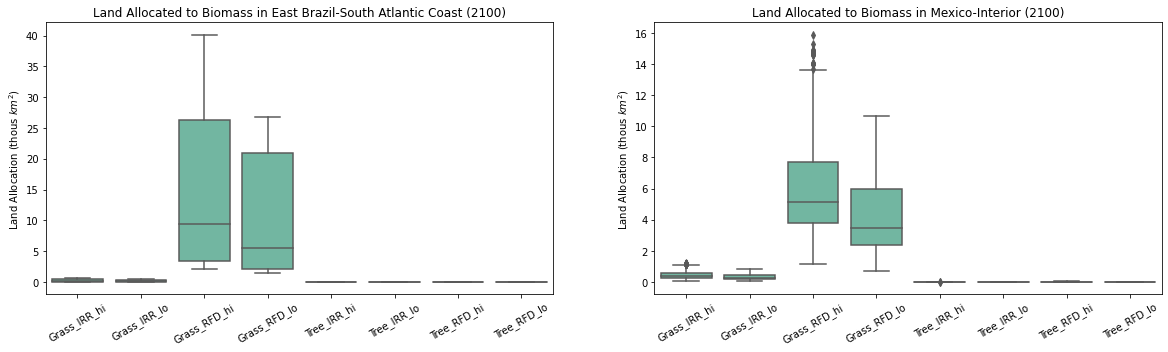

In [16]:
#bmass allocation

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))

bmass_lalloc_ebsac = pd.read_pickle(fpath+'query_results/bmass_alloc_ebsac')
sns.boxplot(ax=ax1,data=bmass_lalloc_ebsac,x='landleaf',y='value',color=sns.color_palette('Set2',1)[0])
ax1.set_xticklabels(['Grass_IRR_hi','Grass_IRR_lo','Grass_RFD_hi','Grass_RFD_lo',
                     'Tree_IRR_hi','Tree_IRR_lo','Tree_RFD_hi','Tree_RFD_lo'],rotation=30)
ax1.set_title('Land Allocated to Biomass in East Brazil-South Atlantic Coast (2100)')
ax1.set_xlabel('')
ax1.set_ylabel('Land Allocation (thous $km^2$)')

bmass_lalloc_mexint = pd.read_pickle(fpath+'query_results/bmass_alloc_mexint')
sns.boxplot(ax=ax2,data=bmass_lalloc_mexint,x='landleaf',y='value',color=sns.color_palette('Set2',1)[0])
ax2.set_xticklabels(['Grass_IRR_hi','Grass_IRR_lo','Grass_RFD_hi','Grass_RFD_lo',
                     'Tree_IRR_hi','Tree_IRR_lo','Tree_RFD_hi','Tree_RFD_lo'],rotation=30)
ax2.set_title('Land Allocated to Biomass in Mexico-Interior (2100)')
ax2.set_xlabel('')
ax2.set_ylabel('Land Allocation (thous $km^2$)')
plt.show()

# Figure S22. Biomass tech yields in East Brazil-South Atlantic Coast and Mexico-Interior in 2100 (by ESM)

This figure plots biomass tech yields in the East Brazil-South Atlantic Coast and Mexico-Interior basins

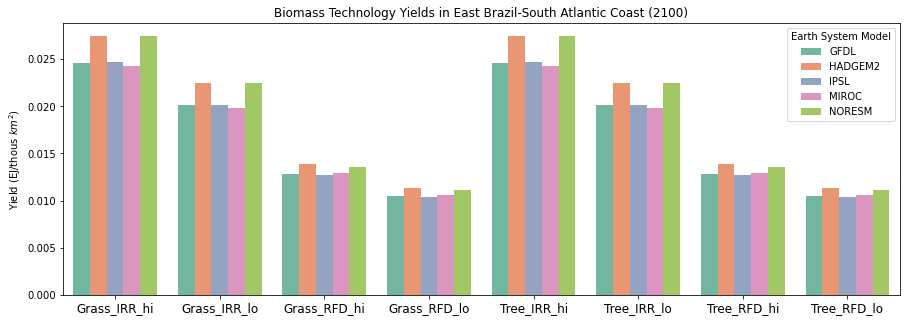

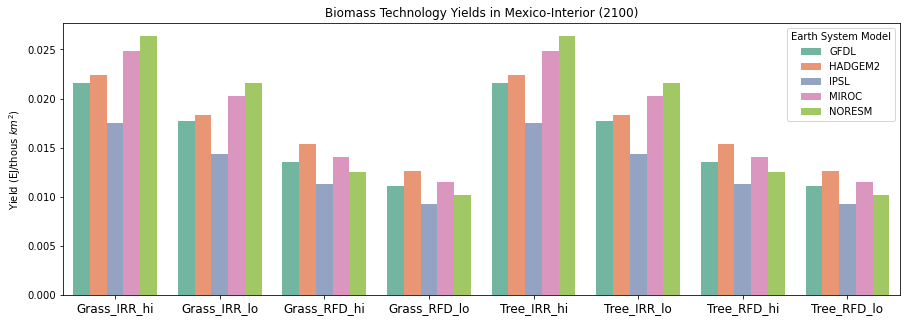

In [17]:
bmass_yield_ebsac = pd.read_pickle(fpath+'query_results/ebsac_bmass_yield')

fig,ax1 = plt.subplots(1,1,figsize=(15,5))
sns.barplot(ax=ax1,data=bmass_yield_ebsac,x='technology',y='value',hue='esm',palette='Set2',
            order = ['biomass_grass_BrzCstE_IRR_hi','biomass_grass_BrzCstE_IRR_lo',
         'biomass_grass_BrzCstE_RFD_hi' ,'biomass_grass_BrzCstE_RFD_lo',
         'biomass_tree_BrzCstE_IRR_hi', 'biomass_tree_BrzCstE_IRR_lo',
         'biomass_tree_BrzCstE_RFD_hi' ,'biomass_tree_BrzCstE_RFD_lo']
           )
ax1.set_title('Biomass Technology Yields in East Brazil-South Atlantic Coast (2100)')
ax1.set_ylabel('Yield (EJ/thous $km^2$)')
ax1.set_xlabel('')
ax1.set_xticklabels(['Grass_IRR_hi','Grass_IRR_lo','Grass_RFD_hi','Grass_RFD_lo',
                    'Tree_IRR_hi','Tree_IRR_lo','Tree_RFD_hi','Tree_RFD_lo'],rotation=0,fontsize=12)
ax1.legend(title='Earth System Model')
plt.show()

bmass_yield_mexint = pd.read_pickle(fpath+'query_results/mexint_bmass_yield')


fig,ax1 = plt.subplots(1,1,figsize=(15,5))
sns.barplot(ax=ax1,data=bmass_yield_mexint,x='technology',y='value',hue='esm',palette='Set2',
            order = ['biomass_grass_MexInt_IRR_hi','biomass_grass_MexInt_IRR_lo',
         'biomass_grass_MexInt_RFD_hi' ,'biomass_grass_MexInt_RFD_lo',
         'biomass_tree_MexInt_IRR_hi', 'biomass_tree_MexInt_IRR_lo',
         'biomass_tree_MexInt_RFD_hi' ,'biomass_tree_MexInt_RFD_lo']
           )
ax1.set_title('Biomass Technology Yields in Mexico-Interior (2100)')
ax1.set_ylabel('Yield (EJ/thous $km^2$)')
ax1.set_xlabel('')
ax1.set_xticklabels(['Grass_IRR_hi','Grass_IRR_lo','Grass_RFD_hi','Grass_RFD_lo',
                    'Tree_IRR_hi','Tree_IRR_lo','Tree_RFD_hi','Tree_RFD_lo'],rotation=0,fontsize=12)
ax1.legend(title='Earth System Model')
plt.show()

# Figure S23. Crop production in East Brazil-South Atlantic Coast and Mexico-Interior basins (by SOC)

This figure plots crop production in the East Brazil-South Atlantic Coast and Mexico-Interior basins for five scenarios that share all parameter assumptions except for SOC (SSP1-5)

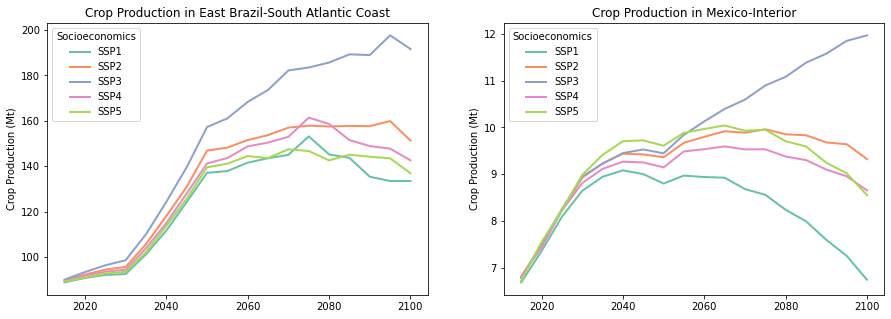

In [18]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

ebsac_agprod_soc = pd.read_pickle(fpath+'query_results/ebsac_soc_agprod')

#sum across technologies
ebsac_agprod_soc_sum = ebsac_agprod_soc.groupby(['Units','sector','output','year','soc'])['value'].sum()
ebsac_agprod_soc_sum = ebsac_agprod_soc_sum.reset_index()

#sum up across sectors - exclude biomass, forest, and pasture
ebsac_agprod_soc_sum = ebsac_agprod_soc_sum[~(ebsac_agprod_soc_sum['sector'].isin(['biomass','Pasture','Forest']))]
ebsac_agprod_soc_sum = ebsac_agprod_soc_sum.groupby(['Units','year','soc'])['value'].sum()
ebsac_agprod_soc_sum = ebsac_agprod_soc_sum.reset_index()

#plot production
sns.lineplot(ax=ax1,data=ebsac_agprod_soc_sum[ebsac_agprod_soc_sum.year>=2015],x='year',y='value',hue='soc',lw=2,palette='Set2')
ax1.set_xlabel('')
ax1.set_ylabel('Crop Production ('+ebsac_agprod_soc_sum['Units'].iloc[0]+')')
ax1.set_title('Crop Production in East Brazil-South Atlantic Coast')
ax1.legend(title='Socioeconomics',labels=['SSP1','SSP2','SSP3','SSP4','SSP5'])


mexint_agprod_soc = pd.read_pickle(fpath+'query_results/mexint_soc_agprod')

#sum across technologies
mexint_agprod_soc_sum = mexint_agprod_soc.groupby(['Units','sector','output','year','soc'])['value'].sum()
mexint_agprod_soc_sum = mexint_agprod_soc_sum.reset_index()

#sum up across sectors - exclude biomass, forest, and pasture
mexint_agprod_soc_sum = mexint_agprod_soc_sum[~(mexint_agprod_soc_sum['sector'].isin(['biomass','Pasture','Forest']))]
mexint_agprod_soc_sum = mexint_agprod_soc_sum.groupby(['Units','year','soc'])['value'].sum()
mexint_agprod_soc_sum = mexint_agprod_soc_sum.reset_index()

#plot production
sns.lineplot(ax=ax2,data=mexint_agprod_soc_sum[mexint_agprod_soc_sum.year>=2015],x='year',y='value',hue='soc',lw=2,palette='Set2')
ax2.set_xlabel('')
ax2.set_ylabel('Crop Production ('+mexint_agprod_soc_sum['Units'].iloc[0]+')')
ax2.set_title('Crop Production in Mexico-Interior')
ax2.legend(title='Socioeconomics',labels=['SSP1','SSP2','SSP3','SSP4','SSP5'])

plt.show()

# Figure S24. Crop profit in Rio Grande (by TAX)

This figure plots crop profit over time in the Rio Grande basin for two scenarios that share all parameter assumptions except for TAX (one is FFICT, one is UCT) and their corresponding unconstrained scenarios

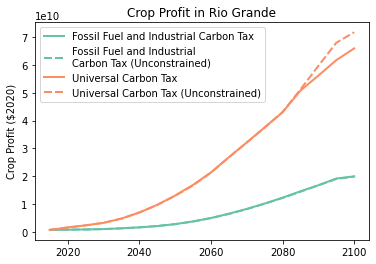

In [19]:
# Rio Grande Tax profit

riogrande_tax_profit = pd.read_pickle(fpath+'query_results/riogrande_tax_profit')
cf = 3.81
riogrande_tax_profit['value_profit'] = riogrande_tax_profit['value_profit']*cf #convert to $2020

#group across extra columns
riogrande_tax_profit = riogrande_tax_profit.groupby(['scenario','scen_or_unc','year','basin','crop'])['value_profit'].sum()
riogrande_tax_profit = riogrande_tax_profit.reset_index()

riogrande_tax_profit_sum = riogrande_tax_profit.groupby(['scenario','scen_or_unc','year','basin'])['value_profit'].sum()
riogrande_tax_profit_sum = riogrande_tax_profit_sum.reset_index()


sns.lineplot(data=riogrande_tax_profit_sum,x='year',y='value_profit',hue='scenario',palette='Set2',lw=2,style='scen_or_unc',
            style_order=['Scenario','Unconstrained'],hue_order=['FFICT','UCT'])
plt.xlabel('')
plt.ylabel('Crop Profit ($2020)')
plt.title('Crop Profit in Rio Grande')
plt.legend(['Fossil Fuel and Industrial Carbon Tax',
            'Fossil Fuel and Industrial \nCarbon Tax (Unconstrained)',
            'Universal Carbon Tax',
            'Universal Carbon Tax (Unconstrained)'])
plt.show()

# Figure S25. Cropland Allocation in Rio Grade basin in 2100

This figure compares cropland allocation between two scenarios that share all scenario assumptions except for TAX. Also includes the cropland allocation in 2100 for the corresponding unconstrained water scenarios

In [20]:
#load in land allocation data for rio grande under two tax policies
rg_tax_lalloc_as = pd.read_pickle(fpath+'query_results/riogrande_tax_lalloc_allsevere')
                                
#split up landleaf
rg_tax_lalloc_as[['crop','basin','wtype','wlevel']] = rg_tax_lalloc_as['landleaf'].str.rsplit('_',n=3,expand=True)

#limit to just crops and year 2100
crop_list = ['Corn','FiberCrop','FodderGrass','FodderHerb','MiscCrop','OilCrop',
 'OtherGrain','PalmFruit','Rice','Root_Tuber','SugarCrop','Wheat']
rg_tax_lalloc_as = rg_tax_lalloc_as[(rg_tax_lalloc_as.crop.isin(crop_list)) & (rg_tax_lalloc_as.year==2100)]

#let's sum up cropland allocation
rg_tax_lalloc_as_sum = rg_tax_lalloc_as.groupby(['Units','scenario','year'])['value'].sum()
rg_tax_lalloc_as_sum = rg_tax_lalloc_as_sum.reset_index()

#load in land allocation for rio grande under same tax policies but with unconstrained water
lalloc_unlim = pd.read_pickle(fpath+'query_results/land_alloc_unlim')

#split up landleaf
lalloc_unlim[['crop','basin','wtype','wlevel']] = lalloc_unlim['landleaf'].str.rsplit('_',n=3,expand=True)

#limit to year 2100 and rio grande basin
lalloc_unlim = lalloc_unlim[(lalloc_unlim.year==2100) & (lalloc_unlim.basin=='RioGrande')]


#look just at cropland allocation
crop_list = ['Corn','FiberCrop','FodderGrass','FodderHerb','MiscCrop','OilCrop',
 'OtherGrain','PalmFruit','Rice','Root_Tuber','SugarCrop','Wheat']
lalloc_unlim = lalloc_unlim[lalloc_unlim.crop.isin(crop_list)]
#sum across crops
lalloc_unlim_sum = lalloc_unlim.groupby(['scenario','Units','year','tax'])['value'].sum()
lalloc_unlim_sum = lalloc_unlim_sum.reset_index()

In [21]:
#merge the scenarios with the unlimited
lalloc_merge = pd.concat([rg_tax_lalloc_as_sum,lalloc_unlim_sum])
lalloc_merge['scen_unlim'] = 'Unconstrained Water'
lalloc_merge.loc[lalloc_merge['scenario'].str.contains('ffict'),'tax'] = 'Fossil Fuel and Industrial Carbon Tax'
lalloc_merge.loc[lalloc_merge['scenario'].str.contains('uct'),'tax'] = 'Universal Carbon Tax'
lalloc_merge.loc[lalloc_merge['scenario'].str.contains('gw'),'scen_unlim'] = 'Scenario'

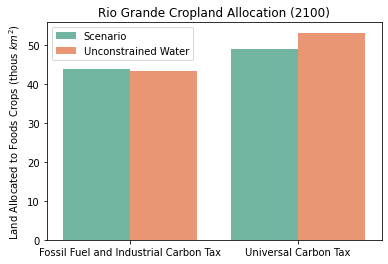

In [22]:
fig,(ax1) = plt.subplots(1,1)
sns.barplot(ax=ax1,data=lalloc_merge,x='tax',y='value',hue='scen_unlim',palette='Set2')
ax1.set_ylabel('Land Allocated to Foods Crops (thous $km^2$)')
ax1.set_xlabel('')
ax1.set_title('Rio Grande Cropland Allocation (2100)')
plt.legend(title='')
plt.show()